# Anomaly Detection Investigation

## Let's first look at the data

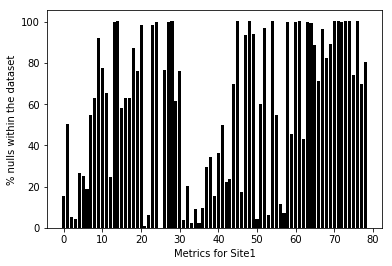

In [322]:
import pandas as pd
import matplotlib.pyplot as plt

file_name = open("data1_site1.json","r")
df = pd.read_json(file_name, lines=True)

nulls = {}
for index,row in df.iterrows():
    count = 0
    for el in row[0]["datapoints"]:
        if el[0] == 0:
            count += 1
    nulls[row[0]["target"]] = (count/17472)*100
    

plt.bar(range(len(nulls)), list(nulls.values()), align='center',color="black")
plt.ylabel("% nulls within the dataset")
plt.xlabel("Metrics for Site1")
plt.show()

## Anomaly Detection - First Attempt

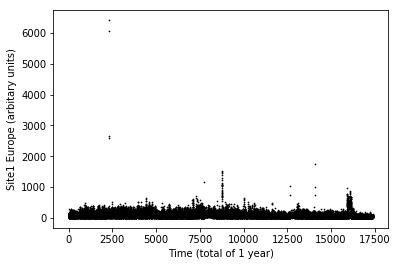

In [323]:
import numpy as np
import re
from anomaly_bot import strip_unix, dataset_load

# Load Data

load_name = "data1_Europe.json"
selected_data = dataset_load(load_name)
p = re.search('(?<=_)[^\.]+',load_name)
name = p.group()

# Plot data removing any 0s which were null values in the original dataset

def plot_all(selected_data, name):
    plt.scatter(np.linspace(1,len(selected_data),len(selected_data)),selected_data,s=0.5,c="black")
    plt.xlabel("Time (total of 1 year)")
    plt.ylabel("Site1 "+name+" (arbitary units)")
    plt.show()

stripped_data = strip_unix(selected_data)
val = 0
while val in stripped_data:
    stripped_data.remove(val)    
plot_all(stripped_data,name)


dt = 1800s (Sample Time)
fa = 0.00056Hz (Frequency)


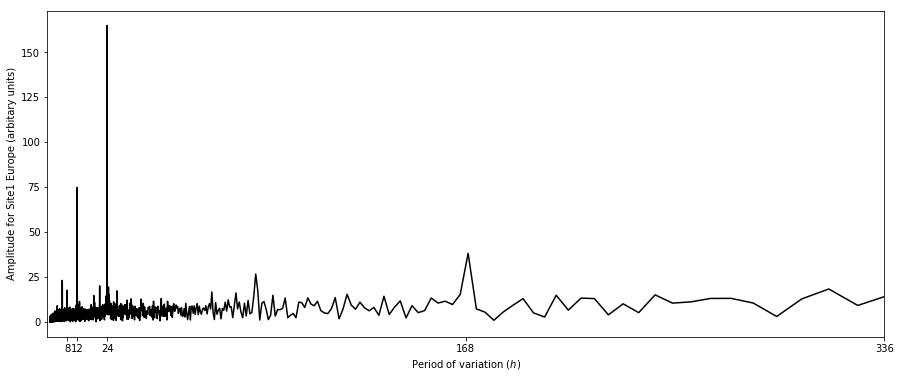

In [179]:
def FFT(selected_data, name):

    # Perform FFT

    stripped_data = strip_unix(selected_data)
    Y = np.fft.fft(stripped_data)
    N = (len(Y)/2)+1

    # Sampling period is 1800s. Nyquists theorem says that we can therefore sample frequencies
    # at most half of the maximum frequency. The X axis is made up of N (length of half of the
    # FFT signal) equally spaced values up to the Nyquist frequency.

    dt = 1800.0
    fa = 1.0/dt

    print('dt = %.fs (Sample Time)' % dt)
    print('fa = %.5fHz (Frequency)' % fa)

    X = np.linspace(0, fa/2, int(N), endpoint=True)

    # Finally we convert the x axis from frequency to period (in hours) for readability.
    
    np.seterr(divide='ignore')
    Xp = 1.0/X
    Xph = Xp/(60.0*60.0)
    plt.figure(figsize=(15,6))
    plt.plot(Xph, 2.0*np.abs(Y[:int(N)])/int(N),'black')
    plt.xticks([8, 12, 24, 168, 336])
    plt.xlim(0, 336)
    plt.xlabel("Period of variation ($h$)")
    plt.ylabel("Amplitude for Site1 "+name+" (arbitary units)")
    plt.show()
    
FFT(selected_data, name)


We can see these daily oscillations fairly easily if we simply plot the average of a particular half-an-hour within a week over the whole year.

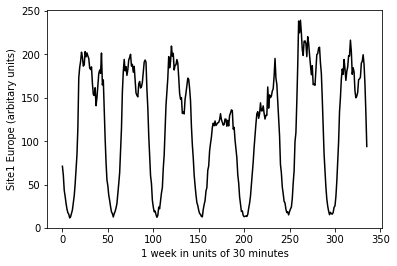

In [324]:
decision_boundary = 800
total_half_hours = 336

def calculate_mean(selected_data,decision_boundary):
    
    stripped_data = strip_unix(selected_data)
    mean_sample = []
    counter = 0
    while counter < total_half_hours:
        sample = []
        for i in range(0,len(stripped_data),total_half_hours):
            if i%total_half_hours==0 and stripped_data[i]!=0 and stripped_data[i]<decision_boundary:
                sample.append(stripped_data[i])
        mean_sample.append(np.mean(sample))
        stripped_data.pop(0)
        counter += 1
    return mean_sample

def plot_average_week(average, name):
    plt.plot(average,'black')
    plt.xlabel("1 week in units of 30 minutes")
    plt.ylabel("Site1 "+name+" (arbitary units)")
    plt.show()

mean_week = calculate_mean(selected_data, decision_boundary)
plot_average_week(mean_week, name)

### Perhaps we can average the same half-an-hour period over the entire year and see what we get?

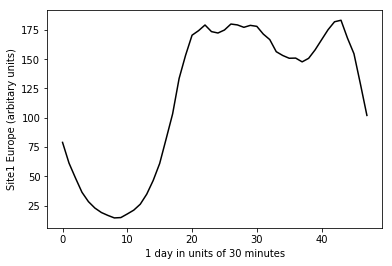

In [325]:
decision_boundary = 800
total_half_hours = 48

def plot_average_day(average, name):
    plt.plot(average,'black')
    plt.xlabel("1 day in units of 30 minutes")
    plt.ylabel("Site1 "+name+" (arbitary units)")
    plt.show()

mean_day = calculate_mean(selected_data, decision_boundary)
plot_average_day(mean_day,name)

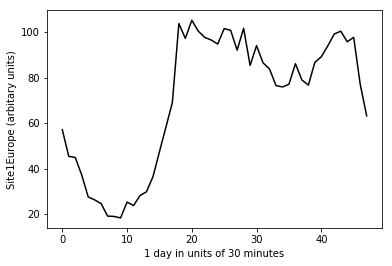

In [326]:
def calculate_sd(selected_data,mean,decision_boundary):
    
    stripped_data = strip_unix(selected_data)
    sd_sample = []
    counter = 0
    while counter < total_half_hours:
        sample = []
        for i in range(0,len(stripped_data),total_half_hours):
            if i%total_half_hours==0 and stripped_data[i]!=0 and stripped_data[i]<decision_boundary:
                sample.append((stripped_data[i]-mean[counter])**2)
        sd_sample.append(np.sqrt(sum(sample)/len(sample)-1))
        stripped_data.pop(0)
        counter +=1
    return sd_sample

def plot_sd(sd, name):
    plt.plot(sd,'black')
    plt.xlabel("1 day in units of 30 minutes")
    plt.ylabel("Site1"+name+" (arbitary units)")
    plt.show()

sd_day = calculate_sd(selected_data,mean,decision_boundary)
plot_sd(sd_day,name)

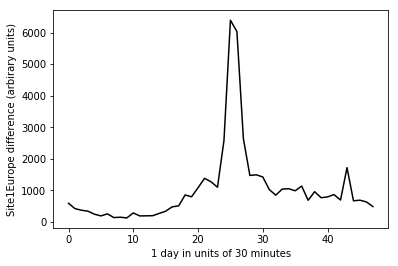

In [327]:
def calculate_max_min_diff(selected_data):
    
    stripped_data = strip_unix(selected_data)
    diff = []
    counter = 0
    while counter < total_half_hours:
        sample = []
        for i in range(len(stripped_data)):
            if i%total_half_hours==0 and stripped_data[i]!=0:
                sample.append(stripped_data[i])
        diff.append(max(sample)-min(sample))
        stripped_data.pop(0)
        counter+=1
    return diff

def plot_diff(diff, name):
    plt.plot(diff,'black')
    plt.xlabel("1 day in units of 30 minutes")
    plt.ylabel("Site1"+name+" difference (arbirary units)")
    plt.show()
    
diff_day = calculate_max_min_diff(selected_data)
plot_diff(diff_day,name)

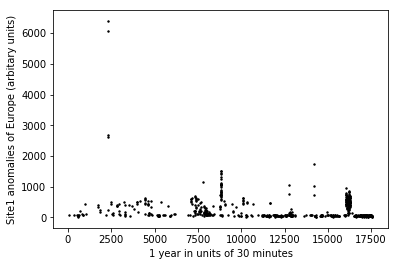

The percentage of anomalies captured by the model is equal to 3.645773433007476 %


In [328]:
def anomaly_detector(selected_data_data,mean,sd):
    
    stripped_data = strip_unix(selected_data)
    anomalies = []
    datapoint = 0
    half_hour = 0
    for val in stripped_data:
        if val**2>(mean[half_hour]+3*sd[half_hour])**2 or val**2<(mean[half_hour]-3*sd[half_hour])**2 and mean[half_hour]-2*sd[half_hour] > 0 and val!=0:
            anomalies.append([val,datapoint])
        half_hour+=1
        half_hour=half_hour%total_half_hours
        datapoint+=1
    return anomalies

def plot_anomaly(anomalies, name):
    for i in anomalies:
        plt.scatter(i[1],i[0],s=2,c="black")
    plt.xlabel("1 year in units of 30 minutes")
    plt.ylabel("Site1 anomalies of "+name+" (arbitary units)")
    plt.show()
    
anomalies_day = anomaly_detector(selected_data,mean,sd)
plot_anomaly(anomalies_day,name)
print("The percentage of anomalies captured by the model is equal to "+str(len(anomalies_day)/len(stripped_data)*100)+" %")

This seems quite high for an anomaly detector? We would ideally have a model which only detects the most serious events.

## Anomaly Detection - Second Attempt

We can see from the plot of the average over a week that there is definitely periodicity over a 24 hour period but that it isn't perfect. The FFT shows also a period of 168 hours which is a week. Perhaps therefore a 1pm on a Monday is like other 1pm Mondays rather than 1pms on all of the days of the week. We will therefore do the same analysis but require that "total_half_hours" = 336. The plots will be as follows:

In [329]:
total_half_hours = 336

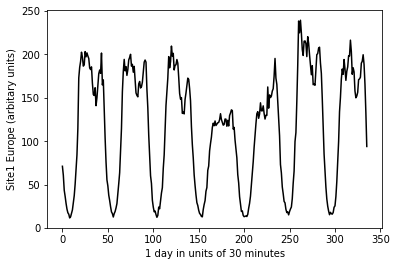

In [330]:
mean_week = calculate_mean(selected_data, decision_boundary)
plot_average_day(mean_week,name)

In [331]:
sd_week = calculate_sd(selected_data,mean_week,decision_boundary)
plot_sd(sd_week,name)

In [332]:
diff_week = calculate_max_min_diff(selected_data)
plot_diff(diff_week,name)

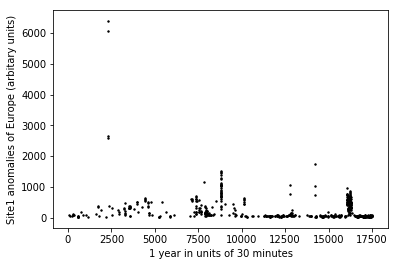

The percentage of anomalies captured by the model is equal to 3.1914893617021276 %


In [333]:
anomalies_week = anomaly_detector(selected_data,mean,sd)
plot_anomaly(anomalies_week,name)
print("The percentage of anomalies captured by the model is equal to "+str(len(anomalies_week)/len(stripped_data)*100)+" %")

The performance it seems is no "better" - we can compare the anomalies picked up by either method by plotting them on the same graph.

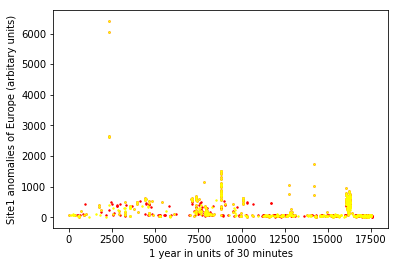

In [334]:
def plot_anomaly_comparison(anomalies_day,anomalies_week,name):
    for i in anomalies_day:
        plt.scatter(i[1],i[0],s=2,c="red")
    for i in anomalies_week:
        plt.scatter(i[1],i[0],s=2,c="yellow")
    plt.xlabel("1 year in units of 30 minutes")
    plt.ylabel("Site1 anomalies of "+name+" (arbitary units)")
    plt.show()

plot_anomaly_comparison(anomalies_day, anomalies_week, name)

We can see that the two methods pick up similiar anomalies. It must be noted there is considerably less data in the latter case since we have only 52 values (the weeks in the year) as oppossed to 365 values (the days in the year) to build our model.

## Does any kind of seasonality exist in all of the metrics anyway?

In [335]:
metric_dictionary = {}
for index, row in df.iterrows():
    metric_dictionary[row[0]["target"]] = row[0]["datapoints"]

plt.figure(figsize=(50,100),facecolor="white")
plot_number = 1

for key, value in metric_dictionary.items():
    
    stripped_data = strip_unix(value)
    Y = np.fft.fft(stripped_data)
    N = (len(Y)/2)+1
    dt = 1800.0
    fa = 1.0/dt
    X = np.linspace(0, fa/2, int(N), endpoint=True)
    np.seterr(divide='ignore')
    Xp = 1.0/X
    Xph = Xp/(60.0*60.0)
    ax = plt.subplot(17,5,plot_number)
    ax.set_xticks([8,12,24,168,336])
    ax.set_xlim(0,336)
    ax.set_title(key)
    ax.plot(Xph, 2.0*np.abs(Y[:int(N)])/int(N),color="black")
    plot_number += 1

plt.show()
    

These plots tell us that we would need to categorise each metric for each site as some appear not to show any seasonality at all - of course this would also be due in part to the fact for many metrics we have almost no data.

## Anomaly Detection - Third (Throw Away?) Attempt

We might try a completely naive version where we average all times (i.e. the entire dataset) such that we have 17520 (the number of half hours in a year) values with which to build a model, hoping that this global model will have enough values to smooth out any noise within the dataset.

In [336]:
def calculate_mean(selected_data):
    stripped_data = strip_unix(selected_data)
    return np.mean(stripped_data)

mean_year = calculate_mean(selected_data)

In [337]:
def calculate_sd(selected_data,mean):
    sd_total = 0
    for i in range(0,len(stripped_data)):
        sd_total += (stripped_data[i]-mean)**2
    sd = np.sqrt(sd_total/len(stripped_data))
    return sd

sd_year = calculate_sd(selected_data,mean_year)

In [338]:
def anomaly_detector(selected_data_data,mean,sd):
    stripped_data = strip_unix(selected_data)
    anomalies = []
    datapoint = 0
    half_hour = 0
    for val in stripped_data:
        if val**2>(mean+3*sd)**2 or val**2<(mean-3*sd)**2 and mean-2*sd > 0 and val!=0:
            anomalies.append([val,datapoint])
        half_hour+=1
        half_hour=half_hour%total_half_hours
        datapoint+=1
    return anomalies

def plot_anomaly(anomalies, name):
    for i in anomalies:
        plt.scatter(i[1],i[0],s=2,c="black")
    plt.xlabel("1 year in units of 30 minutes")
    plt.ylabel("Site1 anomalies of "+name+" (arbitary units)")
    plt.show()
    
anomalies_year = anomaly_detector(selected_data,mean_year,sd_year)
plot_anomaly(anomalies_year,name)
print("The percentage of anomalies captured by the model is equal to "+str(len(anomalies_year)/len(stripped_data)*100)+" %")

The percentage of anomalies captured by the model is equal to 0.8708520689851442 %
